In [96]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB, ComplementNB
stop_words = stopwords.words('english')
stop_words.append('https')

In [97]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, data, y = 0):
        
        return self
    
    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        
        return normalized_corpus
        
    def process_doc(self, doc):

        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [98]:
train= pd.read_csv('sent_train.csv')
test = pd.read_csv('sent_valid.csv')
X_train = train['text']
X_test = test['text']
y_train = train['label']
y_test = test['label']

In [99]:
processor = TextPreprocessor()
X_train_transformed = processor.fit_transform(X_train)

In [100]:
X_train_frame = X_train_transformed.to_frame()

In [101]:
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24)), ('compNB', ComplementNB())]

model_pipe = Pipeline(steps)

In [102]:
model_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000221000E95E0>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000221013ADC10>))]),
                                                  ['text'])])),
                ('compNB', ComplementNB())])

In [103]:
model_pipe.score(X_train_frame, y_train)

0.8771874672534842

In [104]:
X_test_transformed = processor.transform(X_test)
X_test_toframe = X_test_transformed.to_frame()
y_pred = model_pipe.predict(X_test_toframe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       347
           1       0.61      0.72      0.66       475
           2       0.88      0.83      0.85      1566

    accuracy                           0.77      2388
   macro avg       0.69      0.71      0.70      2388
weighted avg       0.78      0.77      0.77      2388



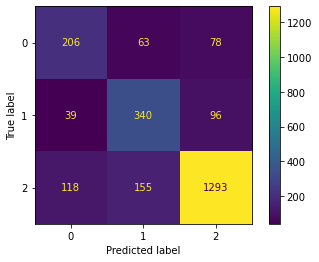

In [105]:
plot_confusion_matrix(model_pipe, X_test_toframe,
                      y_test);